# Data Preparation
Steps to build the source files from the raw data. These steps only need to be repeated when the raw data gets updated.

Main output:
- merged anndata file of all AML samples. Otherwise unprocessed: [tap1_adatas_v2_unprocessed.h5ad]('{output_path}/h5ad/inSitu/tap1_adatas_v2_unprocessed.h5ad')
- re-created and annotated scRNA dataset from GEO with differetial gene expression results: [GSE255530_scRNA_data_s3_dge_results.h5ad]({output_path}/h5ad/scRNA/GSE255530_scRNA_data_s3_dge_results.h5ad')

In [2]:
import numpy as np
import polars as pl
import scanpy as sc
import pandas as pd
import anndata as ad

In [12]:
path_to_source_data = '/home/ubuntu/code/notebooks/tickets/TAP1/data/TAP_DFCI_rep2'
path_to_GEO_data = '/home/ubuntu/code/notebooks/tickets/TAP1/data/scRNA'
output_path = '/home/ubuntu/code/notebooks/tickets/TAP1/output'

In [13]:
sample_info = pl.read_csv(f'{path_to_source_data}/sample_meta.csv')
sample_info.head()

sample_id,patient,timepoint,group,tissue,run,fc,lane
str,str,str,str,str,str,str,str
"""R01_post""","""R01""","""post""","""R""","""BM""","""g4-022_161""","""FC2""","""L001"""
"""R01_pre""","""R01""","""pre""","""R""","""BM""","""g4-022_161""","""FC2""","""L001"""
"""R03_post""","""R03""","""post""","""R""","""BM""","""g4-022_161""","""FC2""","""L002"""
"""R03_pre""","""R03""","""pre""","""R""","""BM""","""g4-022_161""","""FC2""","""L002"""
"""R05_post""","""R05""","""post""","""R""","""BM""","""g4-022_161""","""FC2""","""L003"""


# Collect inSitu adatas and merge into one file
read all adata files from source folder and merge. Sample info is added to metadata (adata.obs)

In [31]:
smps = list(sample_info['sample_id'])
adatas = []

drop_cols = ['TOPRO3_intensity_min', 'TOPRO3_intensity_max', 'TOPRO3_intensity_mean']

for smp in smps:
    tmp_ad = ad.read_h5ad(f'{path_to_source_data}/{smp}/single_cell_data/anndatas/{smp}.h5ad')
    for col in drop_cols:
        if col in tmp_ad.obs.columns:
            tmp_ad.obs = tmp_ad.obs.drop(columns=drop_cols)
            break
    
    tmp_ad.obs['sample_id'] = smp
    adatas.append(tmp_ad)

ad_merge = ad.concat(adatas, axis=0)
ad_merge.obs = ad_merge.obs.merge(sample_info.to_pandas(), on='sample_id', how='left')

# ad_merge.write_h5ad(f'{output_path}/h5ad/inSitu/tap1_adatas_v2_unprocessed.h5ad')

# re-build scRNA data from GEO

In [ ]:
raw_counts = pl.read_csv(f'{path_to_GEO_data}/GEO_GSE255530/GSE255530_counts_data.csv')
meta_data = pl.read_csv(f'{path_to_GEO_data}/metadata_dli.csv')

due to memory restrictions, we need to break down the dense raw-count matrix into quarters, convert to sparse and then assemble to full sparse

In [ ]:
import pickle
import cupy as cp

sparse_matrix_folder = f'{path_to_GEO_data}/sparse_conversion/'

fraction = len(raw_counts)/12 # break into 12 sections
mtx_list = []

for i in range(0,12):
    
    lower = int(fraction*i)
    upper = int(fraction*(i+1))

    sparse_matrix = cp.sparse.csr_matrix(cp.array(raw_counts[lower : upper, 1:]), dtype=np.float64)
    mtx_list.append(sparse_matrix)
    
    cp.save(f"{sparse_matrix_folder}sparse_matrix_intermediate_{i+1}", sparse_matrix)

concatenated_sparse_matrix = cp.sparse.vstack(mtx_list)
del mtx_list

# Convert the CuPy array to a NumPy array
np_array = cp.asnumpy(concatenated_sparse_matrix)

# Save the array using Pickle protocol 4
with open(sparse_matrix_folder + 'sparse_matrix_full.pkl', 'wb') as f:
    pickle.dump(np_array, f, protocol=4)

once we have the sparse matrix, we can create the adata file and add the provided metadata

In [ ]:
with open(sparse_matrix_folder + 'sparse_matrix_full.pkl', 'rb') as file:
    concatenated_sparse_matrix = pickle.load(file)

adata = ad.AnnData(X=concatenated_sparse_matrix)
adata.obs = meta_data.to_pandas()

# add gene names from raw counts
pd_genes = raw_counts[0:1, 1:].transpose(include_header=True).drop('column_0').to_pandas()
genes = pd_genes.set_index('column')
adata.var = genes

# pull umap embeddings from metadata
adata.obsm['X_umap'] = adata.obs[['x', 'y']].values

adata.obs['cluster_number'] = adata.obs['cluster_number'].astype('str')

del concatenated_sparse_matrix, raw_counts

#adata.write_h5ad(f'{output_path}/h5ad/scRNA/GSE255530_scRNA_data_s1_assembled.h5ad')

In [32]:
adata = ad.read_h5ad(f'{output_path}/h5ad/scRNA/GSE255530_scRNA_data_s1_assembled.h5ad')

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.


### umap coordinates and cluster identities seem to match biorxiv figure!

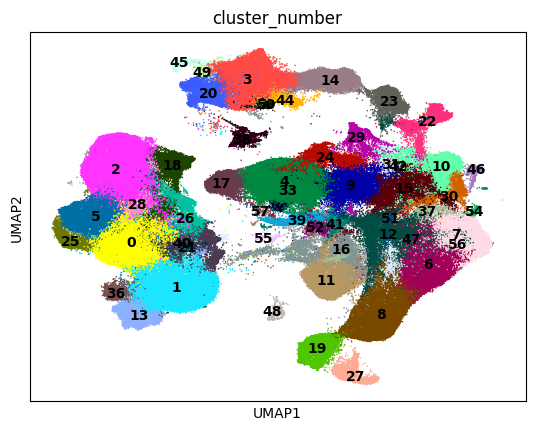

In [33]:
sc.pl.umap(
    adata,
    color=['cluster_number'],
    size=5,
    palette=sc.pl.palettes.default_102,
    legend_loc="on data"
)

### add cell groups from biorxiv for additional annotation

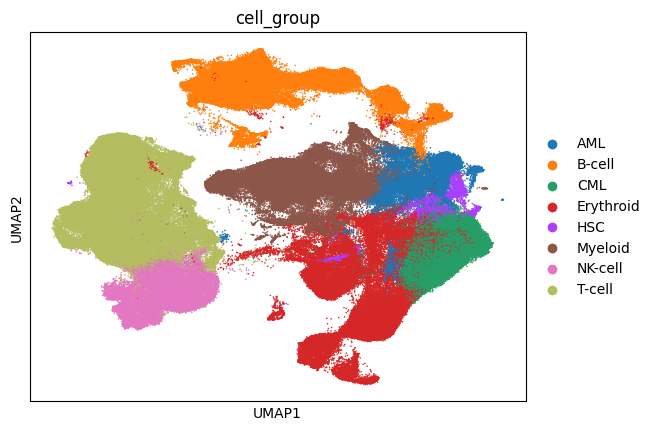

In [35]:
cell_groups = {
    '0': 'T-cell',
    '1': 'NK-cell',
    '2': 'T-cell',
    '3': 'B-cell',
    '4': 'Myeloid',
    '5': 'T-cell',
    '6': 'CML',
    '7': 'CML',
    '8': 'Erythroid',
    '9': 'Myeloid',
    '10': 'AML',
    '11': 'Erythroid',
    '12': 'Erythroid',
    '13': 'NK-cell',
    '14': 'B-cell',
    '15': 'AML',
    '16': 'Erythroid',
    '17': 'Myeloid',
    '18': 'T-cell',
    '19': 'Erythroid',
    '20': 'B-cell',
    '21': 'T-cell',
    '22': 'B-cell',
    '23': 'B-cell',
    '24': 'Myeloid',
    '25': 'T-cell',
    '26': 'T-cell',
    '27': 'Erythroid',
    '28': 'T-cell',
    '29': 'Myeloid',
    '30': 'HSC',
    '31': 'AML',
    '33': 'Myeloid',
    '36': 'NK-cell',
    '37': 'HSC',
    '38': 'B-cell',
    '39': 'Myeloid',
    '40': 'T-cell',
    '41': 'Myeloid',
    '42': 'AML',
    '44': 'B-cell',
    '45': 'B-cell',
    '46': 'AML',
    '47': 'CML',
    '48': 'Erythroid',
    '49': 'B-cell',
    '50': 'B-cell',
    '51': 'Erythroid',
    '52': 'Myeloid',
    '54': 'HSC',
    '55': 'Myeloid',
    '56': 'CML',
    '57': 'Myeloid'
    }

adata.obs['cell_group'] = adata.obs['cluster_number'].map(cell_groups)

sc.pl.umap(
    adata,
    color=['cell_group'],
    size=5,
    palette=sc.pl.palettes.default_20
)

### add further annotation from Table S3

In [37]:
doublet_clusters = [32, 34, 35, 43, 53]

table_s3 = pd.read_excel(f'{path_to_GEO_data}/supp_tables.xlsx', sheet_name='Table S3-clusters', skiprows=2)

clusers_from_s3 = pl.from_pandas(table_s3.drop(doublet_clusters+[58])).select('Cluster ID', 'Major Cell type', 'Refined Cell type', 'Top Celltypist Annotation').rename({'Cluster ID': 'cluster_number'}).to_pandas()
clusers_from_s3['cluster_number'] = clusers_from_s3['cluster_number'].astype('str')

adata.obs = adata.obs.merge(clusers_from_s3, on = 'cluster_number', how='left')

# adata.write_h5ad(f'{output_path}/h5ad/scRNA/GSE255530_scRNA_data_s2_annotated.h5ad')

In [38]:
adata = ad.read_h5ad(f'{output_path}/h5ad/scRNA/GSE255530_scRNA_data_s2_annotated.h5ad')

/home/ubuntu/.pyenv/versions/3.10.14/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.


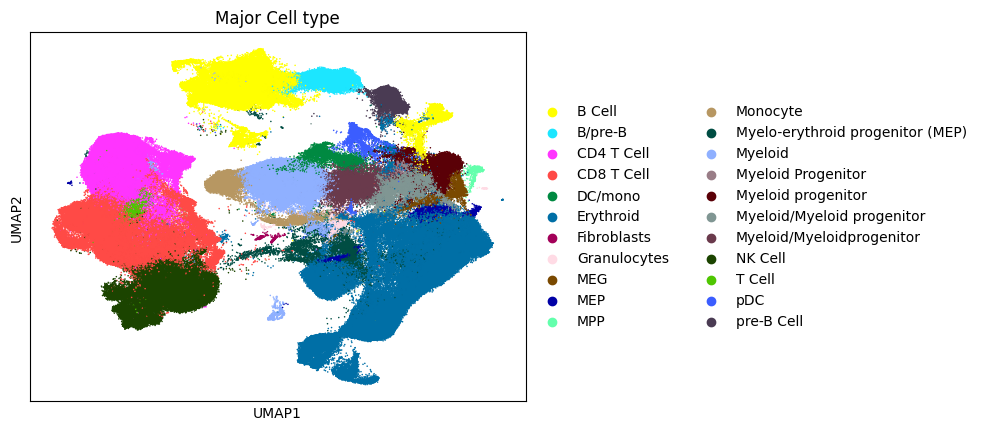

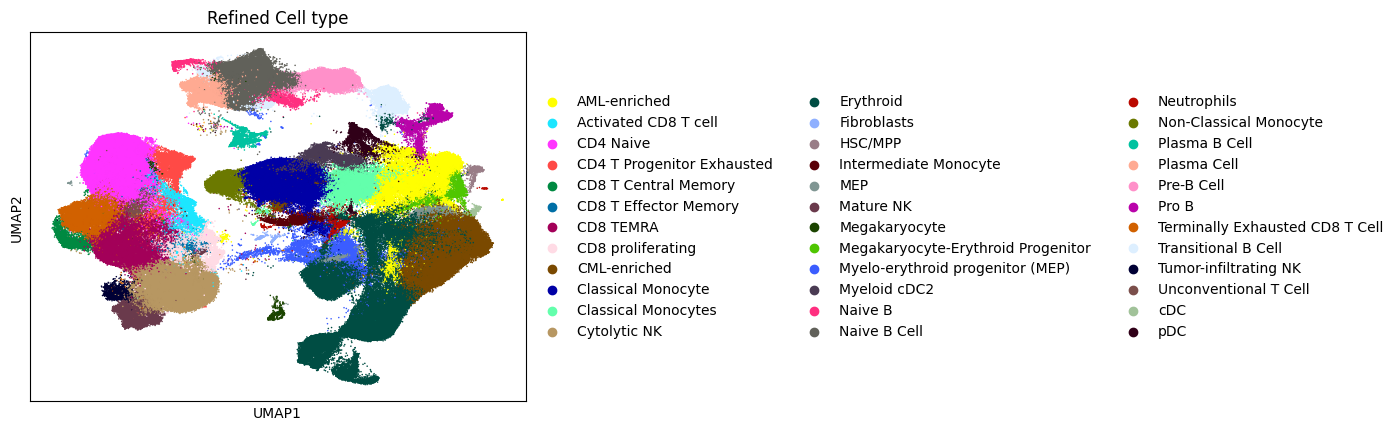

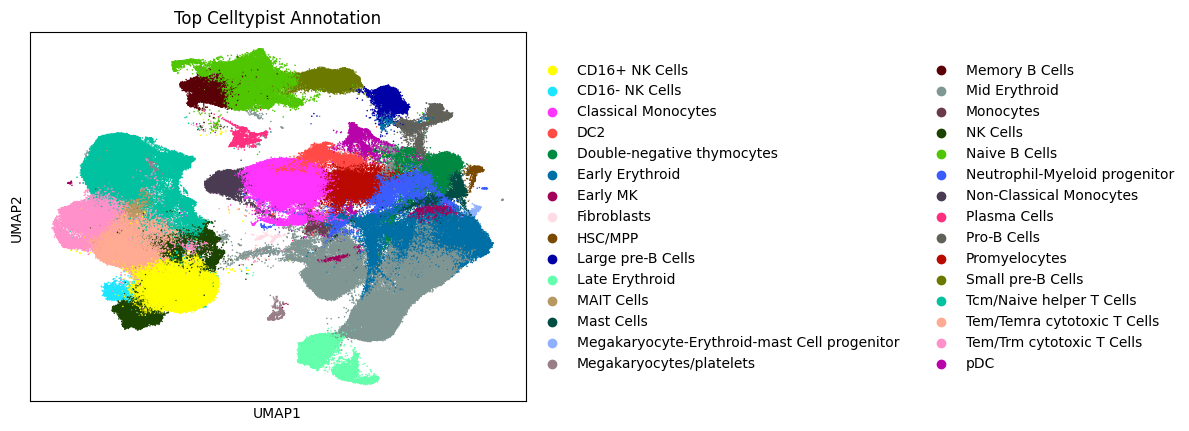

In [39]:
sc.pl.umap(
    adata,
    color=['Major Cell type'],
    size=5,
    palette=sc.pl.palettes.default_102
)

sc.pl.umap(
    adata,
    color=['Refined Cell type'],
    size=5,
    palette=sc.pl.palettes.default_102
)

sc.pl.umap(
    adata,
    color=['Top Celltypist Annotation'],
    size=5,
    palette=sc.pl.palettes.default_102
)

### normalize counts and perform differential gene expression

In [ ]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

sc.tl.rank_genes_groups(adata, "cell_group",                method="wilcoxon", key_added="group_v_rest")
sc.tl.rank_genes_groups(adata, "cluster_number",            method="wilcoxon", key_added="cluster_v_rest")
sc.tl.rank_genes_groups(adata, "Refined Cell type",         method="wilcoxon", key_added="refined_v_rest")
sc.tl.rank_genes_groups(adata, "Major Cell type",           method="wilcoxon", key_added="major_v_rest")
sc.tl.rank_genes_groups(adata, "Top Celltypist Annotation", method="wilcoxon", key_added="celltypist_v_rest")

# adata.write_h5ad(f'{output_path}/h5ad/scRNA/GSE255530_scRNA_data_s3_dge_results.h5ad')